In [1]:
from meld_classifier.paths import BASE_PATH, EXPERIMENT_PATH
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import potpourri3d as pp3d

Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to 
Setting FS_SUBJECTS_PATH to 


In [2]:
features=['.on_lh.curv.mgh',
 '.on_lh.gm_FLAIR_0.25.mgh',
 '.on_lh.gm_FLAIR_0.5.mgh',
 '.on_lh.gm_FLAIR_0.75.mgh',
 '.on_lh.gm_FLAIR_0.mgh',
 '.on_lh.pial.K_filtered.sm20.mgh',
 '.on_lh.sulc.mgh',
 '.on_lh.thickness.mgh',
 '.on_lh.w-g.pct.mgh',
 '.on_lh.wm_FLAIR_0.5.mgh',
 '.on_lh.wm_FLAIR_1.mgh']

In [3]:
## using function 

import sys
sys.path.append('/rds/user/co-ripa1/hpc-work/scripts/meld_classifier_GDL')
from meld_graph.data_preprocessing import Preprocess

site_codes=['H2', 'H3','H4','H5','H6','H7','H9','H10','H11','H12','H14','H15','H16','H17','H18','H19',
                  'H21','H23','H24','H26']
cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix.hdf5', dataset=None)

#create object 
scale = Preprocess(cohort, 
                   site_codes=site_codes, 
                   write_output_file='scaling_params_GDL.json', 
                   data_dir=BASE_PATH)


# for feature in features:
#     scale.compute_scaling_parameters(feature)

In [4]:
listids = cohort.get_subject_ids(site_codes=site_codes, group='both', lesional_only=True)

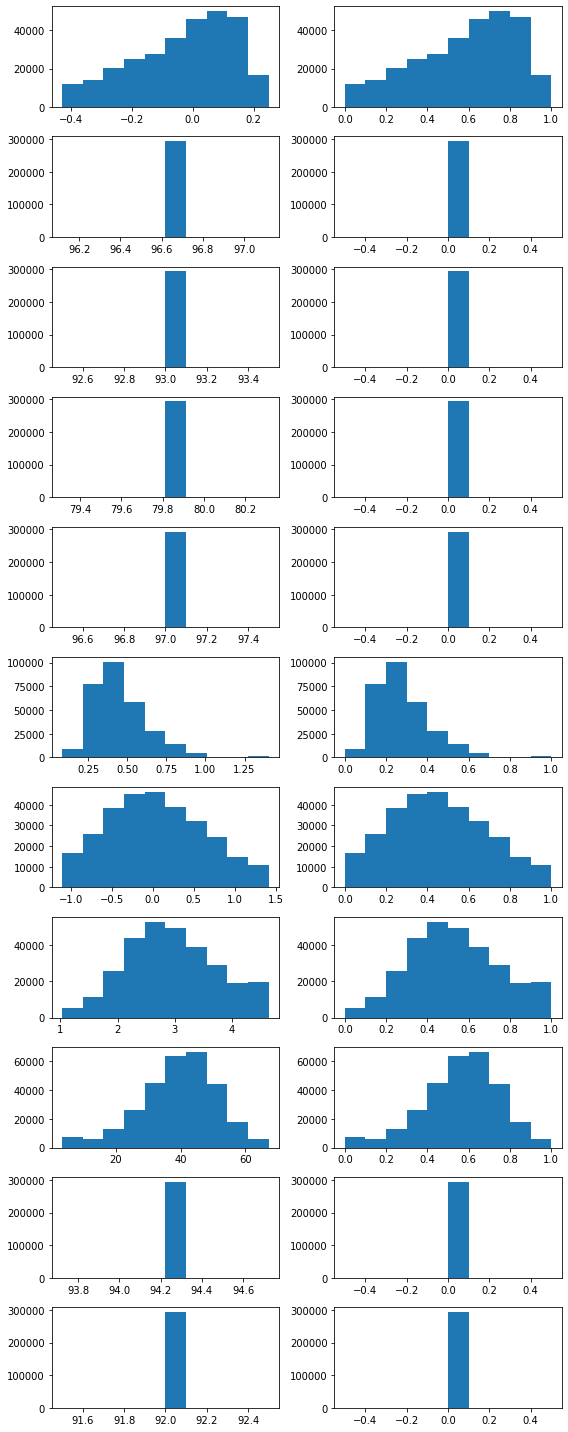

In [5]:
import json
subject = listids[10]

file_name='scaling_params_GDL.json'
file = os.path.join(BASE_PATH, file_name)
with open(file, "r") as f:
    params_norm = json.loads(f.read())
            
subj = MeldSubject(subject, cohort=cohort)
#load data & lesion
vals_array_lh, lesion_lh = subj.load_feature_lesion_data(features, hemi='lh')
vals_array_rh, lesion_rh = subj.load_feature_lesion_data(features, hemi='rh')
vals_array = np.array(np.hstack([vals_array_lh[cohort.cortex_mask].T, vals_array_rh[cohort.cortex_mask].T]))
lesion_array = np.array(np.hstack([lesion_lh[cohort.cortex_mask].T, lesion_rh[cohort.cortex_mask].T]))



#scale data
scaled_data = scale.scale_data(vals_array, features, file_name)

#check scaling
import matplotlib.pyplot as plt
  
fig,axes = plt.subplots(11,2,figsize=(8,20))
for f, feature in enumerate(features):
    #clip data
    min_val = float(params_norm[feature]["min"])
    max_val = float(params_norm[feature]["max"])
    vals_array[f][vals_array[f]<min_val]= min_val
    vals_array[f][vals_array[f]>max_val]= max_val
    axes[f,0].hist(vals_array[f] )
    axes[f,1].hist(scaled_data[f])
    
plt.tight_layout()

In [11]:
#include medial wall back with 0
NVERT=163842

data_lh = np.zeros((len(features),NVERT))
data_rh = np.zeros((len(features),NVERT))
n_vert_cortex = sum(cohort.cortex_mask)

data_lh[:,cohort.cortex_mask] = vals_array[:, 0 : n_vert_cortex]
data_rh[:, cohort.cortex_mask] = vals_array[:, n_vert_cortex : n_vert_cortex*2]
preprocessed_data = np.array(np.hstack([data_lh, data_rh]))

In [8]:
preprocessed_data.shape

(11, 327684)

In [13]:
preprocessed_data2 = np.zeros((len(features),NVERT*2))
cohort_mask_hemis = np.hstack([cohort.cortex_mask,cohort.cortex_mask])
preprocessed_data2[:, cohort_mask_hemis] = vals_array

In [16]:
(preprocessed_data2==preprocessed_data).any()

True